In [2]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["font.family"] = "Times New Roman"

import plotly.express as px
import plotly.graph_objects as go

In [776]:
def create_2d_plot(df, per_modal, x_modal, y_modal, leg_modal, title=None, x_log=False, figsize_ratio=(5, 3)):
    u_modal = df[per_modal].unique()

    fig, axs = plt.subplots(1, len(u_modal), figsize=(figsize_ratio[0]*len(u_modal), figsize_ratio[1]), layout='constrained')

    legend_handles = []
    for d_i, dataset in enumerate(u_modal):
        ax = axs[d_i]
        df_temp = df[df[per_modal] == dataset]

        len_methods = len(df_temp[leg_modal].unique())
        colors = list(matplotlib.colormaps.get_cmap("Set1")(np.linspace(0, 1, 9)))
        colors = colors[1:3] + colors[4:5] + colors[6:8]
        
        for i, method in enumerate(df_temp[leg_modal].unique()):
            df_method = df_temp[df_temp[leg_modal] == method]
            df_method = df_method.sort_values(by=x_modal)
            
            # Define color for the current method
            # Use continuous colormap
            color = "red" if "gzip" in method else colors[i%len(colors)]

            scatter_shape = "*" if "gzip" in method else "o" if method in ["MLP", "CNN", "ResNet", "GRU", "LSTM"] else "^"
            size = 500 if "gzip" in method else 300
            scatter_plot = ax.scatter(df_method[x_modal], df_method[f"{y_modal}_mean"], color=color, label=method, s=size, marker=scatter_shape)
            line_plot, = ax.plot(df_method[x_modal], df_method[f"{y_modal}_mean"], color=color)
            ax.errorbar(df_method[x_modal], df_method[f"{y_modal}_mean"], 
                            yerr=df_method[f"{y_modal}_sem"], 
                            capsize=10, 
                            elinewidth=3,
                            fmt='o', color=color)
            
            if d_i == 0:  # Only add to legend once
                legend_handles.append(scatter_plot)
            
            # if d_i == len(u_modal) // 2:
            #     ax.legend()
        
        ax.set_xlabel(x_modal)
        ax.set_ylabel(y_modal)
        if x_log:
            ax.set_xscale("log")
        ax.set_xticks(df[x_modal].unique())
        ax.set_xticklabels(df[x_modal].unique())
        
        ax.set_title(f"{dataset}")
    fig.suptitle(f"{y_modal} per {x_modal} per {leg_modal}" if title is None else title)
    fig.legend(handles=legend_handles, loc='lower center', ncol=len_methods//2+1, bbox_to_anchor=(0.5, 1.01))
    # fig.tight_layout(rect=[0, 0.1, 1, 0.95])

    return fig, axs

In [ ]:
def create_bar_plot():
    pass

In [4]:
class DeepExpCfg:
    def __init__(self, name) -> None:
        self.dataset="_".join(name.split("_")[1:-6])
        self.n_shots, self.models, _, _, self.benchmark, self.seed=name.split("_")[-6:]
    
    def __repr__(self) -> str:
        return f"{self.dataset}_{self.n_shots}_{self.models}_{self.benchmark}_{self.seed}"
    
    def to_tuple(self):
        return (self.dataset, int(self.n_shots), self.models, int(self.seed))

class ShallowpExpCfg:
    def __init__(self, name) -> None:
        self.dataset="_".join(name.split("_")[1:-4])
        self.n_shots, self.models, self.benchmark, self.seed=name.split("_")[-4:]
    
    def __repr__(self) -> str:
        return f"{self.dataset}_{self.n_shots}_{self.models}_{self.benchmark}_{self.seed}"
    
    def to_tuple(self):
        return (self.dataset, int(self.n_shots), self.models, int(self.seed))

class GzipExpCfg:
    def __init__(self, name) -> None:
        self.dataset="_".join(name.split("_")[1:-6])
        self.n_shots, self.decimal, self.k, self.method, self.benchmark, self.seed=name.split("_")[-6:]
    
    def __repr__(self) -> str:
        return f"{self.dataset}_{self.n_shots}_{self.decimal}_{self.k}_{self.method}_{self.benchmark}_{self.seed}"
    
    def to_tuple(self):
        return (self.dataset, int(self.n_shots), int(self.decimal), int(self.k), self.method, int(self.seed))

# Gzip

In [286]:
# selected_models = {
#     "mitbih_arr-S":     ("mitbih_arr", 1, 6, 1 ),
#     "mitbih_arr-M":     ("mitbih_arr", 3, 2, 1 ),
#     "mitbih_arr-L":     ("mitbih_arr", 32, 4, 1),
#     "mitbih_auth-S":  ("mitbih_auth", 2, 3, 1),
#     "mitbih_auth-M":  ("mitbih_auth", 8, 3, 1),
#     "mitbih_auth-L":  ("mitbih_auth", 16, 2, 1),
#     "pamap2-S":         ("pamap2", 1, 2, 1,     ),
#     "pamap2-M":         ("pamap2", 3, 2, 3,     ),
#     "pamap2-L":         ("pamap2", 32, 2, 1,    )
# }

selected_models = [
    ("mitbih_arr", 32, 4, 1),
    ("mitbih_auth", 16, 2, 1),
    ("pamap2", 32, 2, 1,    )
]

## Acc

In [648]:
exp_folder = "exp1_rungzip_variousparam_0724"
exp_dir = Path(f"../results/journal/") / exp_folder

# make multiindex dataframe
accuracies = {}

for dir in exp_dir.iterdir():
    # memory_usage = pd.read_csv(dir / "memory_usage.csv")
    try:
        cfg = GzipExpCfg(dir.name)
        
        if cfg.method != "all":
            continue
        # if cfg.to_tuple()[:-2] not in selected_models.values():
        #     continue
        
        if cfg.to_tuple()[:-2] not in selected_models:
            continue
        
        df = pd.read_csv(dir / "accuracy.csv")
        
        row = df.loc[df.iloc[:,0] == "bacc", "accuracy"].values
        if row.shape[0] == 0:
            continue
        row = row[0]
        # print(cfg)
        # print(row)
        
        accuracies[cfg.to_tuple()] = row
    except Exception as e:
        print(f"Error: {e} in {dir}")
        continue

# create multiindex dataframe
index = pd.MultiIndex.from_tuples(accuracies.keys(), names=["dataset", "n_shots", "decimal", "k", "method", "seed"])
df = pd.DataFrame(accuracies.values(), index=index, columns=["accuracy"])
df = df.sort_index()


df = df.reset_index()
df["n_shots"] = df["n_shots"].astype(int)
df["k"] = df["k"].astype(int)
df["seed"] = df["seed"].astype(int)
df["accuracy"] = df["accuracy"].astype(float)

# exclude rows with n-shots bigger than 32
df_acc = df.copy()
df_acc = df_acc[(df_acc["decimal"] != "None")]
df_acc["decimal"] = df_acc["decimal"].astype(int)

df_acc.head()

,dataset,n_shots,decimal,k,method,seed,accuracy
0,mitbih_arr,32,4,1,all,0,0.722478
1,mitbih_arr,32,4,1,all,1,0.656840
2,mitbih_arr,32,4,1,all,2,0.775754
3,mitbih_arr,32,4,1,all,3,0.707384
4,mitbih_arr,32,4,1,all,4,0.704556


## Memory

In [650]:
exp_folder = "exp5_rungzip_specific_0710"
exp_dir = Path(f"../results/journal/") / exp_folder

peak_memory_usage = {}

for i, dir in enumerate(sorted(list(exp_dir.iterdir()))):
    try:
        cfg = GzipExpCfg(dir.name)
        
        if cfg.method != "all":
            continue
        # if cfg.to_tuple()[:-2] not in selected_models.values():
        #     continue
        if cfg.to_tuple()[:-2] not in selected_models:
            continue
        
        df = pd.read_csv(dir / "memory_usage.csv")
        
        # if cfg.dataset != "pamap2" :
        #     continue
        
        # if cfg.n_shots != "256":
        #     continue
        
        df["time"] = df["time"] - df.loc[0, "time"]
        
        df = df.sort_values("time")
        
        first_log = df.loc[0, "memory"]
        second_log = df.loc[1, "memory"]
        third_log = df.loc[2, "memory"]
        
        memory_classifier_holds_at_first = second_log - first_log
        memory_caused_by_threading = third_log - second_log
        
        
        df["memory"] = df["memory"] - first_log
        df.loc[2:, "memory"] = df.loc[2:, "memory"] - memory_caused_by_threading
        df["memory"] = df["memory"] / 2**20
        df = df.iloc[1:]
        
        peak_memory = df["memory"].max()
        # print(f"{cfg} - Peak memory: {peak_memory} MB")
        # print(f"memory_classifier_holds_at_first: {memory_classifier_holds_at_first/2**10} KB")
        # print(f"Memory caused by threading: {memory_caused_by_threading/2**10} KB")
        
        peak_memory_usage[cfg.to_tuple()] = peak_memory
        
        # if i < 3:
        #     fig, ax = plt.subplots(figsize=(3, 2))
        #     ax.plot(df["time"], df["memory"])
        #     ax.set_title(cfg)
        #     ax.set_xlabel("Time (s)")
        #     ax.set_ylabel("Memory (MB)")
        #     fig.tight_layout()
        #     plt.show()
    
        
    except Exception as e:
        print(f"Error: {e} in {dir}")
        continue

index = pd.MultiIndex.from_tuples(peak_memory_usage.keys(), names=["dataset", "n_shots", "decimal", "k", "method", "seed"])
df = pd.DataFrame(peak_memory_usage.values(), index=index, columns=["peak_memory"])

df = df.reset_index()
df["n_shots"] = df["n_shots"].astype(int)
df["decimal"] = df["decimal"].astype(int)
df["k"] = df["k"].astype(int)
df["seed"] = df["seed"].astype(int)
df["peak_memory"] = df["peak_memory"].astype(float)

# sort df by columns
df = df.sort_values(["dataset", "n_shots", "decimal", "k", "method", "seed"])
df = df.reset_index(drop=True)

# # exclude rows with n-shots bigger than 32
# df = df[df["n_shots"] <= 32]
# df = df[df["k"] != 15]

df_mem = df.copy()
df.head()

Error: [Errno 2] No such file or directory: '../results/journal/exp5_rungzip_specific_0710/_mitbih_arr_32_4_1_all_False_0/memory_usage.csv' in ../results/journal/exp5_rungzip_specific_0710/_mitbih_arr_32_4_1_all_False_0
Error: [Errno 2] No such file or directory: '../results/journal/exp5_rungzip_specific_0710/_mitbih_auth_16_2_1_all_False_0/memory_usage.csv' in ../results/journal/exp5_rungzip_specific_0710/_mitbih_auth_16_2_1_all_False_0


,dataset,n_shots,decimal,k,method,seed,peak_memory
0,mitbih_arr,32,4,1,all,0,1.132812
1,mitbih_arr,32,4,1,all,1,1.128906
2,mitbih_arr,32,4,1,all,2,1.144531
3,mitbih_arr,32,4,1,all,3,1.128906
4,mitbih_arr,32,4,1,all,4,1.171875


## Process

In [652]:
# assert len(df_acc) == len(df_mem), f"acc: {len(df_acc)}, mem: {len(df_mem)}"

df_gzip = pd.merge(df_acc, df_mem, on=["dataset", "n_shots", "decimal", "k", "method", "seed"], how="outer")

In [653]:
# print(selected_models.items())
# df_gzip["model"] = df_gzip.apply(lambda x: [k for k, v in selected_models.items() if v == tuple(x[["dataset", "n_shots", "decimal", "k"]].tolist())][0], axis=1)
# df_gzip["model"] = df_gzip.apply(lambda x: f"gzip-{x['decimal']}-{x['k']}", axis=1)
df_gzip["model"] = df_gzip.apply(lambda x: f"gzip", axis=1)
# replace model: dataset to gzip string
# example: f"{dataset}-S to "gzip-S"

# df_gzip["model"] = df_gzip["model"].apply(lambda x: x.replace("_", "-"))
# for dataset in ["mitbih-arr", "mitbih-auth", "pamap2"]:
#     df_gzip["model"] = df_gzip["model"].apply(lambda x: x.replace(dataset, "gzip"))

df_gzip = df_gzip.drop(columns=["decimal", "k", "method"])

df_gzip.head()

,dataset,n_shots,seed,accuracy,peak_memory,model
0,mitbih_arr,32,0,0.722478,1.132812,gzip
1,mitbih_arr,32,1,0.656840,1.128906,gzip
2,mitbih_arr,32,2,0.775754,1.144531,gzip
3,mitbih_arr,32,3,0.707384,1.128906,gzip
4,mitbih_arr,32,4,0.704556,1.171875,gzip


# Shallow

## Acc

In [722]:
exp_folder = "exp2_runshallow_acc_0707"
exp_dir = Path(f"../results/journal/") / exp_folder

# make multiindex dataframe
accuracies = {}

for dir in exp_dir.iterdir():
    try:
        cfg = ShallowpExpCfg(dir.name)
        df = pd.read_csv(dir / "accuracy.csv")
        
        row = df.loc[df.iloc[:,0] == "bacc", "accuracy"].values
        if row.shape[0] == 0:
            continue
        row = row[0]
        
        accuracies[cfg.to_tuple()] = row
    except Exception as e:
        print(f"Error: {e} in {dir}")
        continue

# create multiindex dataframe
index = pd.MultiIndex.from_tuples(accuracies.keys(), names=["dataset", "n_shots", "model", "seed"])
df = pd.DataFrame(accuracies.values(), index=index, columns=["accuracy"])
df = df.sort_index()

df = df.reset_index()
df = df[df["model"] != "NB"]

df_acc = df.copy()
df_acc["n_shots"] = df_acc["n_shots"].astype(int)
df_acc["seed"] = df_acc["seed"].astype(int)
df_acc["accuracy"] = df_acc["accuracy"].astype(float)

df_acc.head()

,dataset,n_shots,model,seed,accuracy
0,mitbih_arr,1,AB,0,0.289454
1,mitbih_arr,1,AB,1,0.194118
2,mitbih_arr,1,AB,2,0.328888
3,mitbih_arr,1,AB,3,0.265337
4,mitbih_arr,1,AB,4,0.178979


## Mem

In [723]:
exp_folder = "exp4_runshallow_benchmark_0710"
exp_dir = Path(f"../results/journal/") / exp_folder
peak_memory_usage = {}

for i, dir in enumerate(sorted(list(exp_dir.iterdir()))):
    try:
        cfg = ShallowpExpCfg(dir.name)
        df = pd.read_csv(dir / "memory_usage.csv")
        
        # if cfg.models != "MLP":
        #     continue
        
        df["time"] = df["time"] - df.loc[0, "time"]
        
        df = df.sort_values("time")
        
        first_log = df.loc[0, "memory"]
        second_log = df.loc[1, "memory"]
        third_log = df.loc[2, "memory"]
        
        memory_classifier_holds_at_first = second_log - first_log
        memory_caused_by_threading = third_log - second_log
        
        
        df["memory"] = df["memory"] - first_log
        df.loc[2:, "memory"] = df.loc[2:, "memory"] - memory_caused_by_threading
        df["memory"] = df["memory"] / 2**20
        df = df.iloc[1:]
        
        peak_memory = df["memory"].max()
        # print(f"{cfg} - Peak memory: {peak_memory} MB")
        # print(f"memory_classifier_holds_at_first: {memory_classifier_holds_at_first/2**10} KB")
        # print(f"Memory caused by threading: {memory_caused_by_threading/2**10} KB")
        
        peak_memory_usage[cfg.to_tuple()] = peak_memory
        
        if i < 0:
            fig, ax = plt.subplots(figsize=(3, 2))
            ax.plot(df["time"], df["memory"])
            ax.set_title(cfg)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Memory (MB)")
            fig.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Error: {e} in {dir}")
        continue

index = pd.MultiIndex.from_tuples(peak_memory_usage.keys(), names=["dataset", "n_shots", "model", "seed"])
df = pd.DataFrame(peak_memory_usage.values(), index=index, columns=["peak_memory"])

df = df.reset_index()
df["n_shots"] = df["n_shots"].astype(int)
df["seed"] = df["seed"].astype(int)
df["peak_memory"] = df["peak_memory"].astype(float)

df = df[df["model"] != "NB"]

# sort df by columns
df = df.sort_values(["dataset", "n_shots", "model", "seed"])
df = df.reset_index(drop=True)

# # exclude rows with n-shots bigger than 32
# df = df[df["n_shots"] <= 32]
# df = df[df["k"] != 15]

df_mem = df.copy()

# # Get models who do not have all the dataset, n_shots in df
# f_ms = []
# for model in df['model'].unique():
#     for dataset in df['dataset'].unique():
#         for n_shots in df['n_shots'].unique():
#             if len(df[(df['model'] == model) & (df['dataset'] == dataset) & (df['n_shots'] == n_shots)]) == 0:
#                 f_ms.append((model, dataset, n_shots))
# df_mem = df_mem[~df_mem['model'].isin([f[0] for f in f_ms])]

df_mem.head()

,dataset,n_shots,model,seed,peak_memory
0,mitbih_arr,1,AB,0,2.296875
1,mitbih_arr,1,AB,1,2.269531
2,mitbih_arr,1,AB,2,2.261719
3,mitbih_arr,1,AB,3,2.218750
4,mitbih_arr,1,AB,4,2.250000


## Process

In [724]:
# assert len(df_acc) == len(df_mem), f"acc: {len(df_acc)}, mem: {len(df_mem)}"
    

df_shallow = pd.merge(df_acc, df_mem, on=["dataset", "n_shots", "model", "seed"], how="outer")

df_shallow.head()

,dataset,n_shots,model,seed,accuracy,peak_memory
0,mitbih_arr,1,AB,0,0.289454,2.296875
1,mitbih_arr,1,AB,1,0.194118,2.269531
2,mitbih_arr,1,AB,2,0.328888,2.261719
3,mitbih_arr,1,AB,3,0.265337,2.218750
4,mitbih_arr,1,AB,4,0.178979,2.250000


# Deep

## Acc

In [725]:
exp_folder = "exp6_rundeep_acc_0708"
exp_dir = Path(f"../results/journal/") / exp_folder

# make multiindex dataframe
accuracies = {}

import shutil
for dir in exp_dir.iterdir():
    try:
        cfg = DeepExpCfg(dir.name)
        df = pd.read_csv(dir / "accuracy.csv")
        
        row = df.loc[df.iloc[:,0] == "bacc", "accuracy"].values
        if row.shape[0] == 0:
            print(f"Error: {cfg} - No bacc")
            shutil.rmtree(dir)
            continue
        row = row[0]
        
        accuracies[cfg.to_tuple()] = row
    except Exception as e:
        print(f"Error: {e} in {dir}")
        continue

# create multiindex dataframe
index = pd.MultiIndex.from_tuples(accuracies.keys(), names=["dataset", "n_shots", "model", "seed"])
df = pd.DataFrame(accuracies.values(), index=index, columns=["accuracy"])
df = df.reset_index()

df_acc = df.copy()
df_acc["n_shots"] = df_acc["n_shots"].astype(int)
df_acc["seed"] = df_acc["seed"].astype(int)
df_acc["accuracy"] = df_acc["accuracy"].astype(float)
df_acc.sort_values(["dataset", "n_shots", "model", "seed"], inplace=True)
df_acc.reset_index(drop=True, inplace=True)

df_acc.head()

,dataset,n_shots,model,seed,accuracy
0,mitbih_arr,1,CNN,0,0.304594
1,mitbih_arr,1,CNN,1,0.334304
2,mitbih_arr,1,CNN,2,0.408985
3,mitbih_arr,1,CNN,3,0.266659
4,mitbih_arr,1,CNN,4,0.472740


## Mem

In [726]:
exp_folder = "exp7_rundeep_benchmark_0710"
exp_dir = Path(f"../results/journal/") / exp_folder
peak_memory_usage = {}

j = 0
for i, dir in enumerate(sorted(list(exp_dir.iterdir()))):
    try:
        cfg = DeepExpCfg(dir.name)
        
        df = pd.read_csv(dir / "memory_usage.csv")
        
        
        df["time"] = df["time"] - df.loc[0, "time"]
        
        df = df.sort_values("time")
        
        first_log = df.loc[0, "memory"]
        second_log = df.loc[1, "memory"]
        third_log = df.loc[2, "memory"]
        
        memory_classifier_holds_at_first = second_log - first_log
        memory_caused_by_threading = third_log - second_log
        
        
        df["memory"] = df["memory"] - first_log
        df.loc[2:, "memory"] = df.loc[2:, "memory"] - memory_caused_by_threading
        df["memory"] = df["memory"] / 2**20
        df = df.iloc[1:]
        
        peak_memory = df["memory"].max()
        # print(f"{cfg} - Peak memory: {peak_memory} MB")
        # print(f"memory_classifier_holds_at_first: {memory_classifier_holds_at_first/2**10} KB")
        # print(f"Memory caused by threading: {memory_caused_by_threading/2**10} KB")
        
        peak_memory_usage[cfg.to_tuple()] = peak_memory
        
        if i < 0 or j < 0:
            fig, ax = plt.subplots(figsize=(3, 2))
            ax.plot(df["time"], df["memory"])
            ax.set_title(cfg)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Memory (MB)")
            fig.tight_layout()
            plt.show()
            j += 1
        
    except Exception as e:
        print(f"Error: {e} in {dir}")
        continue

index = pd.MultiIndex.from_tuples(peak_memory_usage.keys(), names=["dataset", "n_shots", "model", "seed"])
df = pd.DataFrame(peak_memory_usage.values(), index=index, columns=["peak_memory"])

df = df.reset_index()
df["n_shots"] = df["n_shots"].astype(int)
df["seed"] = df["seed"].astype(int)
df["peak_memory"] = df["peak_memory"].astype(float)

# sort df by columns
df = df.sort_values(["dataset", "n_shots", "model", "seed"])
df = df.reset_index(drop=True)

# # exclude rows with n-shots bigger than 32
# df = df[df["n_shots"] <= 32]
# df = df[df["k"] != 15]

# copy the rows of seed 0 to 1~9

n_shots = df_gzip["n_shots"].unique()
df = pd.concat([df] * len(n_shots), ignore_index=True)
df.sort_values(["dataset", "n_shots", "model", "seed"], inplace=True)
df["n_shots"] = np.tile(n_shots, df.shape[0] // len(n_shots))

df.sort_values(["dataset", "n_shots", "model", "seed"], inplace=True)
df.reset_index(drop=True, inplace=True)
df_mem = df.copy()

# # Get models who do not have all the dataset, n_shots in df
# f_ms = []
# for model in df['model'].unique():
#     for dataset in df['dataset'].unique():
#         for n_shots in df['n_shots'].unique():
#             if len(df[(df['model'] == model) & (df['dataset'] == dataset) & (df['n_shots'] == n_shots)]) == 0:
#                 f_ms.append((model, dataset, n_shots))
# df_mem = df_mem[~df_mem['model'].isin([f[0] for f in f_ms])]

df_mem.head()

,dataset,n_shots,model,seed,peak_memory
0,mitbih_arr,16,CNN,0,7.820312
1,mitbih_arr,16,CNN,1,7.914062
2,mitbih_arr,16,CNN,2,7.718750
3,mitbih_arr,16,CNN,3,9.730469
4,mitbih_arr,16,CNN,4,10.671875


In [727]:
df_mem_t = df_mem.copy()
df_mem_t = df_mem_t[df_mem_t["model"] == "CNN"]

df_mem_t.head(30)

,dataset,n_shots,model,seed,peak_memory
0,mitbih_arr,16,CNN,0,7.820312
1,mitbih_arr,16,CNN,1,7.914062
2,mitbih_arr,16,CNN,2,7.718750
3,mitbih_arr,16,CNN,3,9.730469
4,mitbih_arr,16,CNN,4,10.671875
5,mitbih_arr,16,CNN,5,10.355469
6,mitbih_arr,16,CNN,6,9.785156
7,mitbih_arr,16,CNN,7,10.687500
8,mitbih_arr,16,CNN,8,9.386719
9,mitbih_arr,16,CNN,9,10.683594


## Process

In [728]:
# assert len(df_acc) == len(df_mem), f"acc: {len(df_acc)}, mem: {len(df_mem)}"
df_deep = pd.merge(df_acc, df_mem, on=["dataset", "n_shots", "model", "seed"], how="outer")

df_deep.head()

,dataset,n_shots,model,seed,accuracy,peak_memory
0,mitbih_arr,1,CNN,0,0.304594,NaN
1,mitbih_arr,1,CNN,1,0.334304,NaN
2,mitbih_arr,1,CNN,2,0.408985,NaN
3,mitbih_arr,1,CNN,3,0.266659,NaN
4,mitbih_arr,1,CNN,4,0.472740,NaN


# Combine

In [729]:
df_all = pd.concat([df_gzip, df_shallow, df_deep], ignore_index=True)

# move order of columns
df_all = df_all[["dataset", "n_shots", "model", "seed", "accuracy", "peak_memory"]]
df_all = df_all.sort_values(["dataset", "n_shots", "model", "seed"])

df_all.head()

,dataset,n_shots,model,seed,accuracy,peak_memory
900,mitbih_arr,1,AB,0,0.289454,2.296875
901,mitbih_arr,1,AB,1,0.194118,2.269531
902,mitbih_arr,1,AB,2,0.328888,2.261719
903,mitbih_arr,1,AB,3,0.265337,2.218750
904,mitbih_arr,1,AB,4,0.178979,2.250000


# ACC-MEM

In [730]:
def sem(df):
    return df.std() / np.sqrt(df.shape[0])

In [731]:
df_acc_mem = df_all.copy()
df_acc_mem["accuracy"] *= 100

df_acc_mem = df_all.groupby(["dataset", "n_shots", "model"]).agg({
    "accuracy": ["mean", "std", "min", "max", sem],
    "peak_memory": ["mean", "std","min", "max", sem]
}).reset_index()
df_acc_mem.columns = ["_".join(col).strip().rstrip('_') for col in df_acc_mem.columns.values]

# for each dataset, find the n_shot that model that "gzip" is in model name has:
for dataset in df_acc_mem["dataset"].unique():
    df_temp = df_acc_mem[df_acc_mem["dataset"] == dataset]
    model_gzip = df_temp["model"].apply(lambda x: "gzip" in x)
    n_shot = df_temp[model_gzip]["n_shots"].unique()[0]
    
    # drop all rows with dataset that does not have the n_shot
    df_acc_mem = df_acc_mem[(df_acc_mem["dataset"] != dataset) | (df_acc_mem["n_shots"] == n_shot)]


# shallow, deep, gzip
plot_order = ["AB", "DT", "GP", "RF", "SVC", "MLP", "CNN", "ResNet", "GRU", "LSTM", "gzip"]
df_acc_mem = df_acc_mem.sort_values("model", key=lambda x: x.map({v: i for i, v in enumerate(plot_order)}))

reprs = {
    "arr": "MIT-BIH Arr",
    "auth": "MIT-BIH Auth",
    "pamap": "PAMAP2"
}

df_acc_mem["dataset"] = df_acc_mem["dataset"].apply(lambda x: [v for k, v in reprs.items() if k in x][0])
df_acc_mem.head()

,dataset,n_shots,model,accuracy_mean,accuracy_std,accuracy_min,accuracy_max,accuracy_sem,peak_memory_mean,peak_memory_std,peak_memory_min,peak_memory_max,peak_memory_sem
60,MIT-BIH Arr,32,AB,0.250466,0.030792,0.204866,0.300250,0.009737,2.169922,0.054353,2.097656,2.257812,0.017188
121,MIT-BIH Auth,16,AB,0.767952,0.036429,0.692314,0.835513,0.011520,1.915625,0.334315,0.968750,2.062500,0.105720
202,PAMAP2,32,AB,0.422033,0.045145,0.380320,0.543568,0.014276,2.209766,0.019922,2.175781,2.234375,0.006300
123,MIT-BIH Auth,16,DT,0.745634,0.032525,0.672373,0.783414,0.010285,0.932422,0.017953,0.906250,0.957031,0.005677
204,PAMAP2,32,DT,0.563014,0.024056,0.535122,0.588187,0.007607,0.969141,0.016720,0.941406,0.992188,0.005287


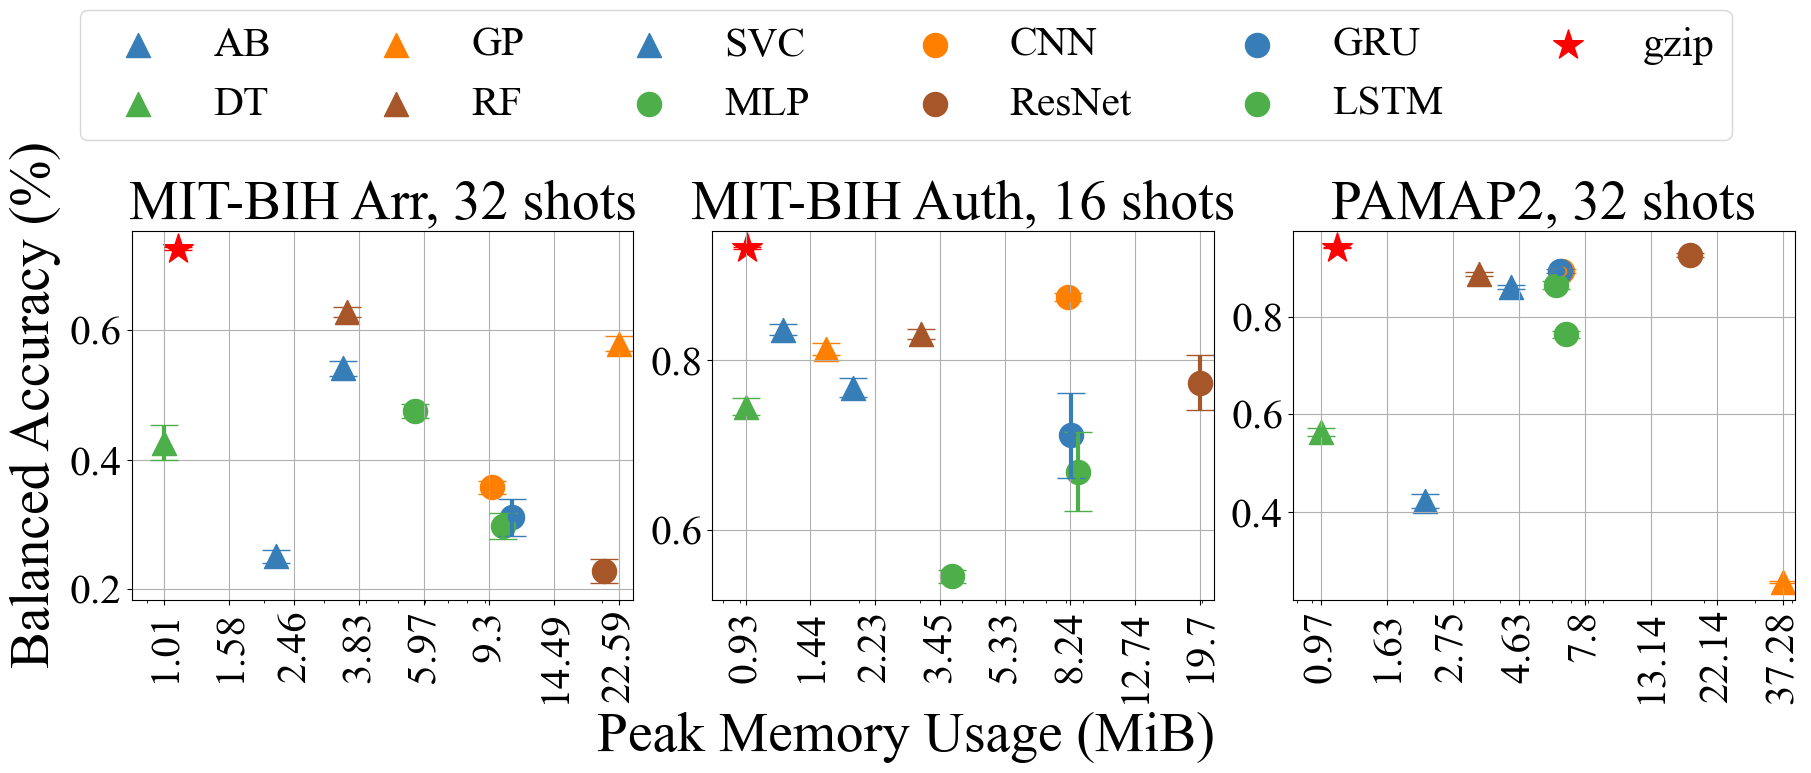

In [777]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

per_modal, x_modal, y_modal, leg_modal = "dataset", "peak_memory_mean", "accuracy", "model"

fig, axs = create_2d_plot(df_acc_mem, per_modal, x_modal, y_modal, leg_modal, figsize_ratio=(6, 6))

u_dataset = df_acc_mem[per_modal].unique()
for d_i, ax in enumerate(axs):
    # set x ticks every 10
    # x_min, x_max = ax.get_xlim()
    df_u = df_acc_mem[df_acc_mem[per_modal] == u_dataset[d_i]]
    
    x_min, x_max = df_u[x_modal].min(), df_u[x_modal].max()
    
    # x_min = max(1, np.floor(x_min/10)*10)
    # x_max = np.ceil(x_max/10)*10
    every = 8
    
    ax.set_xscale('log')
    ls = np.logspace(np.log10(x_min), np.log10(x_max), every, base=10)
    # ls = np.linspace((x_min), (x_max), every)
    ax.set_xticks(ls)
    ax.set_xticklabels(
        [s.round(2) for s in ls]
    )
    ax.set_xbound(lower=x_min*.8, upper=x_max*1.1)
    ax.tick_params(axis='x', which='major', rotation=90)
    ax.tick_params(axis='x', which='minor', rotation=90)
    
    y_min, y_max = df_u[f"{y_modal}_mean"].min(), df_u[f"{y_modal}_mean"].max()
    y_min = np.floor(y_min/10)*10
    y_max = np.ceil(y_max/10)*10
    
    # ls = np.arange(y_min, y_max, 10)
    # # ls = np.linspace((x_min), (x_max), every)
    # ax.set_yticks(ls)
    # ax.set_yticklabels(
    #     [int(s.round(0)) for s in ls]
    # )
    
    ax.set_title(f"{u_dataset[d_i]}, {df_u['n_shots'].unique()[0]} shots", fontsize=40)
    ax.grid(True)
    # ax.legend(loc='best')
    ax.set_xlabel(f"")
    ax.set_ylabel(f"")

fig.supylabel("Balanced Accuracy (%)", y=0.605, fontsize=40)
fig.supxlabel("Peak Memory Usage (MiB)", fontsize=40)
fig.suptitle(f"")
# # fig.tight_layout()
fig.savefig(f"../ploting/journal/acc-mem.png", bbox_inches='tight')  # Save each dataset plot separately
fig.savefig(f"../ploting/journal/acc-mem.pdf", bbox_inches='tight')
plt.show()

matplotlib.rcParams.update({'font.size': 12})

# Shot-memory

# Ablation

In [733]:
exp_folder = "exp9_rungzip_ablation_0709"
exp_dir = Path(f"../results/journal/") / exp_folder

# make multiindex dataframe
accuracies = {}
peak_memory_usage = {}

j = 0
for dir in sorted(exp_dir.iterdir()):
    try:
        cfg = GzipExpCfg(dir.name)
        
        if cfg.benchmark == "True":
            df = pd.read_csv(dir / "memory_usage.csv")
            
            # if cfg.seed > "2":
            #     continue
        
            # if cfg.models != "MLP":
            #     continue
            
            df["time"] = df["time"] - df.loc[0, "time"]
            
            df = df.sort_values("time")
            
            first_log = df.loc[0, "memory"]
            second_log = df.loc[1, "memory"]
            third_log = df.loc[2, "memory"]
            
            memory_classifier_holds_at_first = second_log - first_log
            memory_caused_by_threading = third_log - second_log
            
            
            df["memory"] = df["memory"] - first_log
            df.loc[2:, "memory"] = df.loc[2:, "memory"] - memory_caused_by_threading
            df["memory"] = df["memory"] / 2**20
            df = df.iloc[1:]
            
            peak_memory = df["memory"].max()
            # print(f"{cfg} - Peak memory: {peak_memory} MB")
            # print(f"memory_classifier_holds_at_first: {memory_classifier_holds_at_first/2**10} KB")
            # print(f"Memory caused by threading: {memory_caused_by_threading/2**10} KB")
            # print(df[df["name"] == "set"])
            
            peak_memory_usage[cfg.to_tuple()] = peak_memory
            if j < 0:
                fig, ax = plt.subplots(figsize=(3, 2))
                ax.plot(df["time"], df["memory"])
                ax.set_title(cfg)
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Memory (MB)")
                fig.tight_layout()
                plt.show()
                j += 1
        else:
            df = pd.read_csv(dir / "accuracy.csv")
            
            row = df.loc[df.iloc[:,0] == "bacc", "accuracy"].values
            if row.shape[0] == 0:
                continue
            row = row[0]
            
            accuracies[cfg.to_tuple()] = row
    except Exception as e:
        print(f"Error: {e} in {dir}")
        import traceback
        print(traceback.format_exc())
        continue



# create multiindex dataframe
index = pd.MultiIndex.from_tuples(accuracies.keys(), names=["dataset", "n_shots", "decimal", "k", "method", "seed"])
df_acc = pd.DataFrame(accuracies.values(), index=index, columns=["accuracy"])
df_acc = df_acc.sort_index()
df_acc = df_acc.reset_index()

# append peak memory usage
index = pd.MultiIndex.from_tuples(peak_memory_usage.keys(), names=["dataset", "n_shots", "decimal", "k", "method", "seed"])
df_mem = pd.DataFrame(peak_memory_usage.values(), index=index, columns=["peak_memory"])

df_abl = pd.merge(df_acc, df_mem, on=["dataset", "n_shots", "decimal", "k", "method", "seed"], how="outer")

df_abl = df_abl.drop(columns=["n_shots", "k", "decimal"])
df_abl["seed"]          = df_abl["seed"].astype(int)
df_abl["peak_memory"]   = df_abl["peak_memory"].astype(float)
df_abl["accuracy"]      = df_abl["accuracy"].astype(float)
df_abl.head()

,dataset,method,seed,accuracy,peak_memory
0,mitbih_arr,cw,0,0.775967,NaN
1,mitbih_arr,cw,1,0.687740,NaN
2,mitbih_arr,cw,2,0.793409,NaN
3,mitbih_arr,cw,3,0.712571,NaN
4,mitbih_arr,cw,4,0.698703,NaN


In [734]:
df_gzip_abl = df_gzip.copy()
df_gzip_abl["method"] = df_gzip_abl["model"]
df_gzip_abl = df_gzip_abl.drop(columns=["model", "n_shots"])
df_abl = pd.concat([df_gzip_abl, df_abl], ignore_index=True)
# Only use pamap since it has multi channel
df_abl = df_abl[df_abl["dataset"] == "pamap2"]


df_abl.head()

,dataset,seed,accuracy,peak_memory,method
600,pamap2,0,0.939452,1.160156,gzip
601,pamap2,1,0.937695,1.136719,gzip
602,pamap2,2,0.934905,1.132812,gzip
603,pamap2,3,0.946236,1.140625,gzip
604,pamap2,4,0.947546,1.101562,gzip


In [735]:
df_abl_bar = df_abl.copy()
df_abl_bar["accuracy"] *= 100
# df_abl_bar["peak_memory"]  *= * 2**10

# agg mean and standard error, not standard deviation
df_abl_bar['count'] = df_abl_bar.groupby(["dataset", "method"])['accuracy'].transform('count')

df_abl_bar = df_abl_bar.groupby(["dataset", "method"]).agg({
    "accuracy": ["mean", "std", sem],
    "peak_memory": ["mean", "std", sem]
}).reset_index()


reprs = {
    "arr": "MIT-BIH Arr",
    "auth": "MIT-BIH Auth",
    "pamap": "PAMAP2",
    
    "default": "Vanila",
    "fpq": "FPQ",
    "hybrid": "FPQ+HD",
    "cw": "FPQ+CWC",
    "gzip": "All"
}
df_abl_bar["dataset"] = df_abl_bar["dataset"].apply(lambda x: [v for k, v in reprs.items() if k in x][0])
df_abl_bar["method"] = df_abl_bar["method"].apply(lambda x: [v for k, v in reprs.items() if k in x][0])

df_abl_bar.sort_values("method", key=lambda x: x.map({v: i for i, v in enumerate(reprs.values())}), inplace=True)

df_abl_bar.columns = ["_".join(col).strip().rstrip('_') for col in df_abl_bar.columns.values]
# df_abl_bar.columns = df_abl_bar.columns.str.replace("<lambda_0>", "sem")

df_abl_bar.head()

,dataset,method,accuracy_mean,accuracy_std,accuracy_sem,peak_memory_mean,peak_memory_std,peak_memory_sem
1,PAMAP2,Vanila,51.344376,3.401593,0.196391,1.027409,0.072439,0.004182
2,PAMAP2,FPQ,80.191565,2.023597,0.116832,1.048503,0.029777,0.001719
4,PAMAP2,FPQ+HD,83.489994,1.841471,0.106317,1.116484,0.066347,0.003831
0,PAMAP2,FPQ+CWC,93.821951,0.934609,0.053960,1.018919,0.054711,0.003159
3,PAMAP2,All,94.136782,0.769473,0.044426,1.098203,0.031366,0.001811


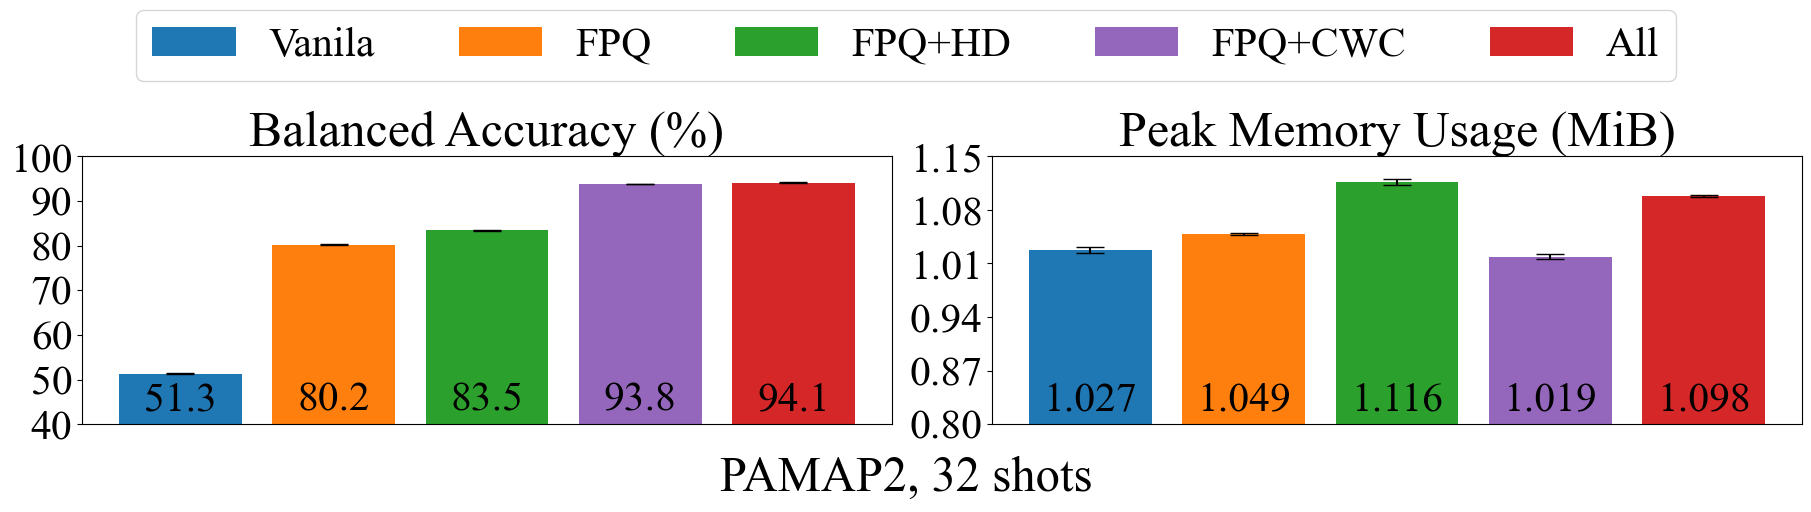

In [738]:
from matplotlib import ticker


matplotlib.rcParams.update({'font.size': 30})

# bar plot with error bar

x_modal, y_modals, leg_modal = "dataset", ["accuracy", "peak_memory"], "method"
value, error = "mean", "sem"

u_legs = df_abl_bar[leg_modal].unique()
# sort u_legs by ["default", "fpq", ""]

x_pos = np.arange(len(df_abl_bar[x_modal].unique()))
width = 0.1  # width of the bars

fig, axs = plt.subplots(1, len(y_modals), figsize=(18, 4), layout='constrained')
legend_handles = []
for ax_i, y_modal in enumerate(y_modals):
    ax = axs[ax_i]
    
    y_value, y_err = f"{y_modal}_{value}", f"{y_modal}_{error}"
    df_temp = df_abl_bar
    
    colors = list(matplotlib.colormaps.get_cmap("tab10")(range(len(u_legs)))) # (np.linspace(0, 1, len(u_legs)))
    colors[-2:] = colors[-2:][::-1]
    
    # colors = ["black"] + colors
    bar_positionss = []
    for i, leg in enumerate(u_legs):
        df_leg = df_temp[df_temp[leg_modal] == leg]
        df_leg = df_leg.sort_values(by=x_modal)
        
        bar_positions = x_pos + i * width
        bar_positionss.append(bar_positions[0])
        bar_plot = ax.bar(
            bar_positions, df_leg[y_value], width-0.02, yerr=df_leg[y_err], 
            capsize=10 , ecolor='black',
            
            label=leg, color=colors[i])

        # write the value on top of the bar
        for bar_i, bar in enumerate(bar_plot):
            height = bar.get_height()
            err = df_leg[y_err].iloc[0] if i == 7 else 0
            text_pos = height+err if i == 7 else 41 if y_modal == "accuracy" else 0.806
            ax.text(bar.get_x() + bar.get_width() / 2, text_pos,
                    f"{height:.1f}" if y_modal == "accuracy" else f"{height:.3f}", 
                ha='center', va='bottom')

        if ax_i == 0:
            legend_handles.append(bar_plot)

    ax.set_xticks([])
    # ax.set_xticks(bar_positionss)
    # u_legs_repr = [r.replace("+", "\n+\n") for r in u_legs]
    # ax.set_xticklabels(u_legs_repr)
    
    
    # ax.yaxis.grid(True)
    
    y_min, y_max = ax.get_ylim()
    if y_modal == "accuracy":
        y_min, y_max = 40, 100
    else:
        y_min, y_max = .8, 1.15
    ax.set_ylim(y_min, y_max)
    
    
    yticks = np.round(np.linspace(y_min, y_max, 7 if y_modal =="accuracy" else 6), 0 if y_modal == "accuracy" else 2)
    ax.set_yticks(yticks)
    yticklabels = [f"{y:.0f}" for y in yticks] if y_modal == "accuracy" else [f"{y:.2f}" for y in yticks]
    # print(yticklabels)
    ax.set_yticklabels(yticklabels)
    # ax.set_yscale("log")
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())  # set regular formatting
    ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())  # set regular formatting
    ax.set_title(f"Balanced Accuracy (%)" if y_modal == "accuracy" else "Peak Memory Usage (MiB)")

fig.supxlabel("PAMAP2, 32 shots", fontsize=35) # , y=0.05
fig.legend(handles=legend_handles, loc='lower center', ncol=len(u_legs), bbox_to_anchor=(0.5, 1.01))
fig.savefig(f"../ploting/journal/ablation.pdf", bbox_inches='tight')
plt.show()
    
    
matplotlib.rcParams.update({'font.size': 12})